In [1]:
import os
import time
from matplotlib import pyplot as plt
import numpy as np
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Reshape, GlobalAveragePooling1D, Activation, GlobalAveragePooling2D
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Conv1D, MaxPooling1D
from tensorflow.python.framework.convert_to_constants import convert_variables_to_constants_v2_as_graph

# Reproducibility
np.random.seed(1917)
tf.random.set_seed(1917)
print('TensorFlow version:', tf.__version__)

physical_devices = tf.config.list_physical_devices('GPU')

if physical_devices:
    print("GPU(s) detected:", physical_devices)
else:
    print("No GPU detected. Keras will run on CPU.")

TensorFlow version: 2.12.0
GPU(s) detected: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


You can estimate how fast a network prediction can be calculated by calculating the number of floating point operations performed in the network. This function is a handy tool to do it. Use it like this `print(get_flops(my_model))` where `my_model` is your KERAS neural network model.

In [2]:
######################################Calculate FLOPS##########################################
def get_flops(model):
    '''
    Calculate FLOPS
    Parameters
    ----------
    model : tf.keras.Model
        Model for calculating FLOPS.

    Returns
    -------
    flops.total_float_ops : int
        Calculated FLOPS for the model
    '''

    batch_size = 1

    real_model = tf.function(model).get_concrete_function(tf.TensorSpec([batch_size] + model.inputs[0].shape[1:], model.inputs[0].dtype))
    frozen_func, graph_def = convert_variables_to_constants_v2_as_graph(real_model)

    run_meta = tf.compat.v1.RunMetadata()
    opts = tf.compat.v1.profiler.ProfileOptionBuilder.float_operation()
    flops = tf.compat.v1.profiler.profile(graph=frozen_func.graph,run_meta=run_meta, cmd='op', options=opts)
    return flops.total_float_ops

Downloading the data (1 signal data file and 5 noise data files)

In [3]:
# download data file that contains signal events
if not os.path.exists("trimmed100_data_signal_3.6SNR_1ch_0000.npy"):
  !gdown https://drive.google.com/uc?id=1t-1icmiJ8Nwu1dm_USIc_W13B68QDwqq

In [4]:
# download data file that contains noise events
if not os.path.exists("trimmed100_data_noise_3.6SNR_1ch_0000.npy"):
  !gdown https://drive.google.com/uc?id=14Aff8wf-e1qTQwWU0I-PkrbdbdtS6dei
if not os.path.exists("trimmed100_data_noise_3.6SNR_1ch_0001.npy"):
  !gdown https://drive.google.com/uc?id=1EkhWgOXOvaK74JiWPOxt6DUE4S5NGYrT
if not os.path.exists("trimmed100_data_noise_3.6SNR_1ch_0002.npy"):
  !gdown https://drive.google.com/uc?id=1BSPvbNOJ2kG7p3ImsVekz4jwXUqlhLRd
if not os.path.exists("trimmed100_data_noise_3.6SNR_1ch_0003.npy"):
  !gdown https://drive.google.com/uc?id=1xoTjcJd762XUAP0I7Ukv0y2go6ZwTmIa
if not os.path.exists("trimmed100_data_noise_3.6SNR_1ch_0004.npy"):
  !gdown https://drive.google.com/uc?id=1CAmatsbjLmhefxvoH4fr7O-8pGA5p4KY
if not os.path.exists("trimmed100_data_noise_3.6SNR_1ch_0005.npy"):
  !gdown https://drive.google.com/uc?id=1lX4M1t8W4zg0wVXA4HYUlnFGU3nMYPGx

Load the data into memory and combine it into one array.

In [5]:
# load signal and noise data set into memory
noise = np.load("trimmed100_data_noise_3.6SNR_1ch_0000.npy")
for i in range(1,5):
  noise = np.vstack((noise,np.load(f"trimmed100_data_noise_3.6SNR_1ch_000{i}.npy")))
signal = np.load("trimmed100_data_signal_3.6SNR_1ch_0000.npy")
n_classes = 2

In [6]:
# combine noise and signal data set
x = np.vstack((noise, signal))
x = np.expand_dims(x, axis=-1)
print(x.shape)
# in case you want to train a CNN, you need to add an empty dimension to the array
# which you can do via x = np.expand_dims(x, axis=-1)

# define labels. As we have only two categories, we don't use one-hot encoding
# but can just use "0" for noise and "1" for signal.
y = np.ones(len(x))
y[:len(noise)] = 0
print(y.shape)

(599997, 100, 1)
(599997,)


Currently, the training data first contains all noise events and then only signal events. This is not optimal, especially because Keras will pick the last X% of the data set for the validation data (which would mean we train only on noise and then validate with signal, which does not make much sense). Therefore, we randomly shuffle the dataset. Important: The x and y arrays need to be shuffled identicially as in the code below.

In [7]:
# Normalize data
x_norm = tf.keras.utils.normalize(x)

# time length
t_len = x_norm.shape[1]

# shuffel the data
shuffle = np.arange(x_norm.shape[0], dtype=int)
np.random.shuffle(shuffle)
x = x[shuffle]
x_norm = x_norm[shuffle]
y = y[shuffle]

# Train/validation split (80/20)
n = len(x)
split = int(0.8 * n)
x_train, x_val = x_norm[:split], x_norm[split:]
y_train, y_val = y[:split], y[split:]


# to still be able to identify the signal events you can do
smask = y == 1
# then you can get all signal events via `x[smask]`
# and all noise events via `x[~smask]`


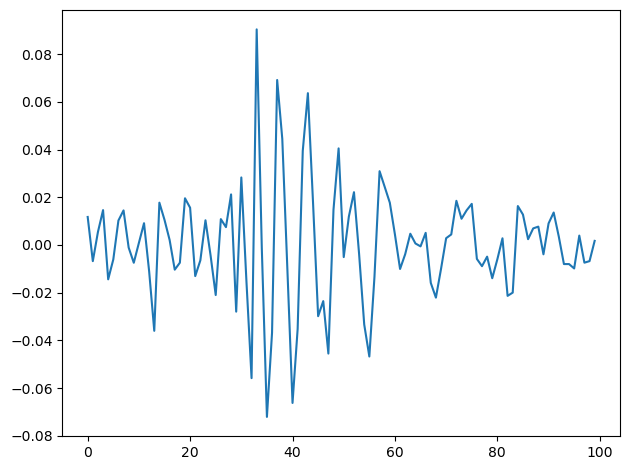

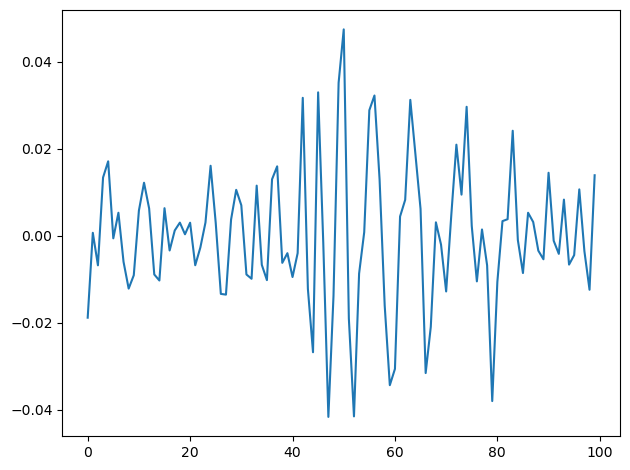

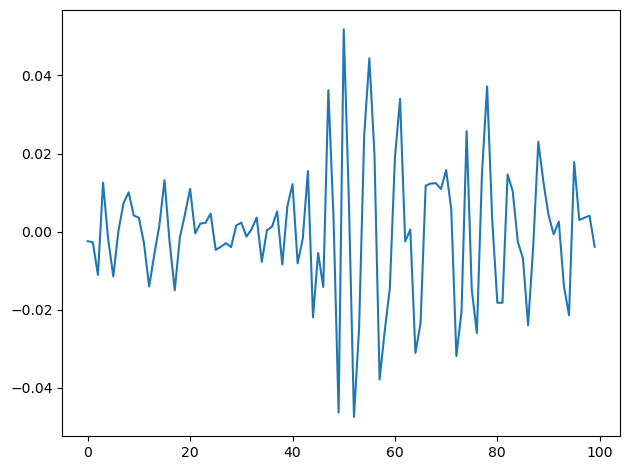

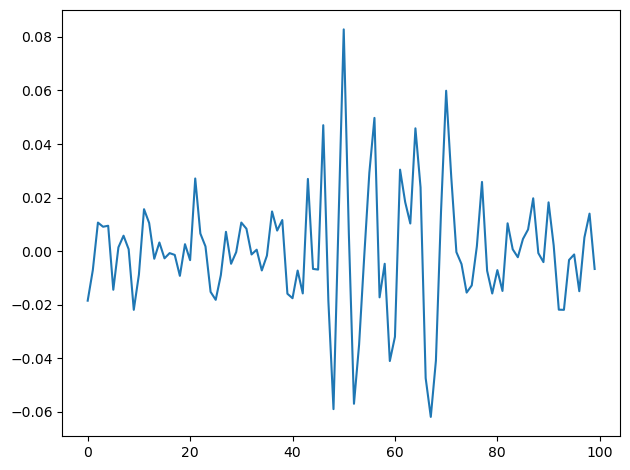

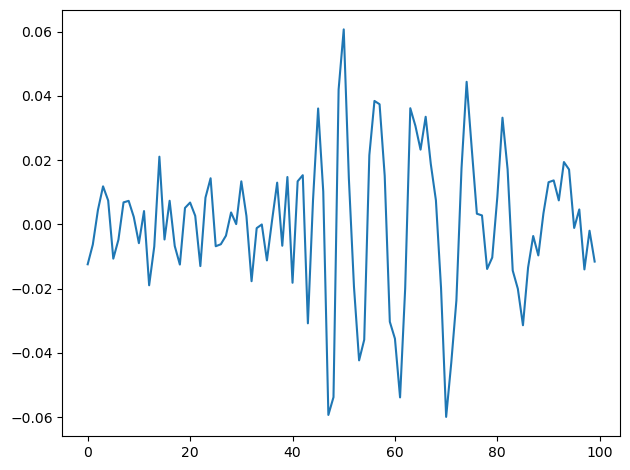

In [8]:
# plot a few signal events
for trace in x[smask][:5]:
  fig, ax = plt.subplots(1, 1)
  ax.plot(trace)
  fig.tight_layout()
  plt.show()

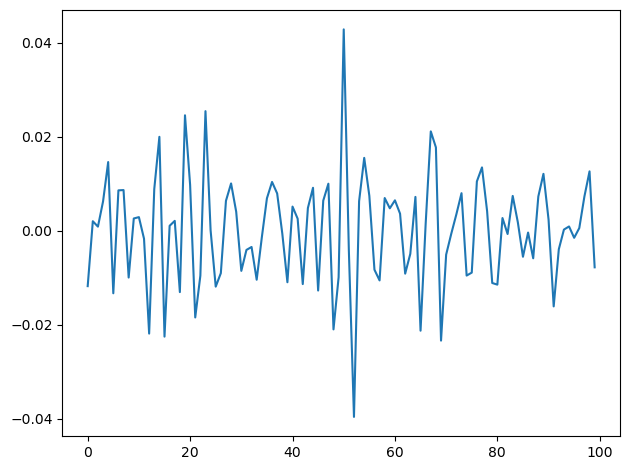

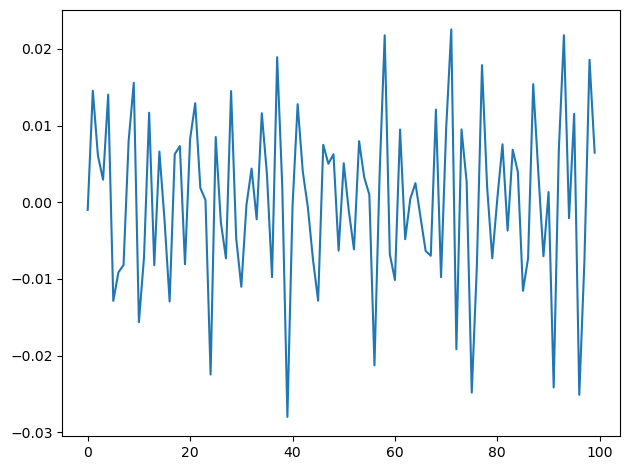

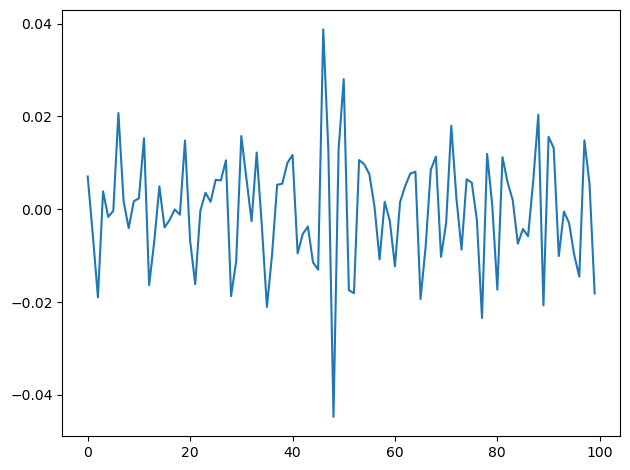

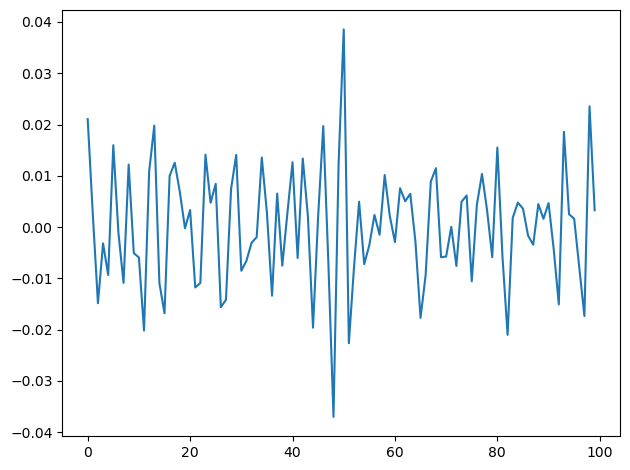

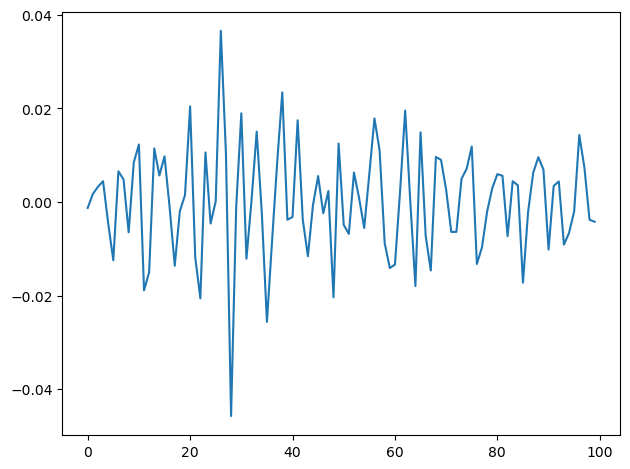

In [9]:
# plot a few noise events
for trace in x[~smask][:5]:
  fig, ax = plt.subplots(1, 1)
  ax.plot(trace)
  fig.tight_layout()
  plt.show()

From plotting signal events and noise events, no clear distinct pattern is observed in order to differentiate them.

In [10]:
model = Sequential(
    [
        keras.layers.Input(shape=(t_len, 1)),
        Conv1D(8, 5, padding='same', activation='relu'),
        MaxPooling1D(2),
        Conv1D(16, 5, padding='same', activation='relu'),
        GlobalAveragePooling1D(),
        Dense(1, activation='sigmoid')
    ],
    name="cnn",
)

print(model.summary())

Model: "cnn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 100, 8)            48        
                                                                 
 max_pooling1d (MaxPooling1D  (None, 50, 8)            0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 50, 16)            656       
                                                                 
 global_average_pooling1d (G  (None, 16)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 1)                 17        
                                                                 
Total params: 721
Trainable params: 721
Non-trainable params: 0

In [11]:
# ----------------------------------------------------------
# Training
# ----------------------------------------------------------
model.compile(
    loss='binary_crossentropy', # only two categories
    optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.001), # For M1/M2 macs works better
    #optimizer = tf.keras.optimizers.Adam(learning_rate=0.001), # keras 3
    metrics=['accuracy']
)


result = model.fit(
    x_train,
    y_train,
    batch_size=1024,
    epochs=30,
    validation_data=(x_val, y_val),
    verbose = 1
)

Epoch 1/30


2025-12-08 12:39:16.175252: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


469/469 [==============================] - 4s 8ms/step - loss: 0.3941 - accuracy: 0.8418 - val_loss: 0.2755 - val_accuracy: 0.8903
Epoch 2/30
469/469 [==============================] - 3s 7ms/step - loss: 0.2452 - accuracy: 0.9072 - val_loss: 0.2255 - val_accuracy: 0.9154
Epoch 3/30
469/469 [==============================] - 3s 7ms/step - loss: 0.2158 - accuracy: 0.9206 - val_loss: 0.2088 - val_accuracy: 0.9228
Epoch 4/30
469/469 [==============================] - 3s 7ms/step - loss: 0.2042 - accuracy: 0.9256 - val_loss: 0.2003 - val_accuracy: 0.9267
Epoch 5/30
469/469 [==============================] - 3s 7ms/step - loss: 0.1976 - accuracy: 0.9282 - val_loss: 0.1955 - val_accuracy: 0.9294
Epoch 6/30
469/469 [==============================] - 3s 7ms/step - loss: 0.1932 - accuracy: 0.9301 - val_loss: 0.1915 - val_accuracy: 0.9313
Epoch 7/30
469/469 [==============================] - 3s 7ms/step - loss: 0.1902 - accuracy: 0.9319 - val_loss: 0.1889 - val_accuracy: 0.9323
Epoch 8/30
469/46

In [12]:
# Predict probabilities on validation set
y_val_pred = model.predict(x_val, batch_size=1024).ravel()

118/118 [==============================] - 0s 2ms/step


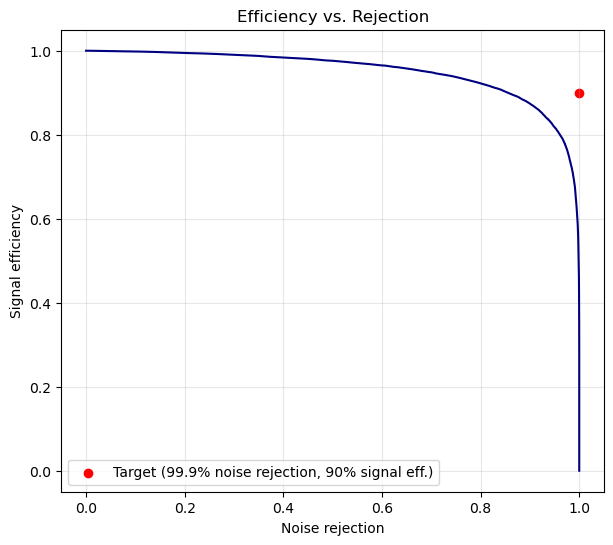

In [13]:
def sweep_thresholds(y_true, y_score, n_steps=1001):
    thresholds = np.linspace(0, 1, n_steps)
    # masks
    smask = y_true == 1
    nmask = y_true == 0
    s_total = max(1, smask.sum())
    n_total = max(1, nmask.sum())
    eff = []  # signal efficiency (True positive response)
    rej = []  # noise rejection (True negative response)
    for t in thresholds:
        y_pred = (y_score >= t).astype(int)
        tp = ((y_pred==1) & smask).sum()
        tn = ((y_pred==0) & nmask).sum()
        eff.append(tp / s_total)
        rej.append(tn / n_total)
    return thresholds, np.array(eff), np.array(rej)

threshold, seff, nrej = sweep_thresholds(y_val, y_val_pred)


# Plot signal efficiency vs noise rejection
plt.figure(figsize=(7,6))
plt.plot(nrej, seff, color='navy')
plt.scatter([0.999], [0.90], color='red', label='Target (99.9% noise rejection, 90% signal eff.)')
plt.xlabel('Noise rejection') # True negative response
plt.ylabel('Signal efficiency') # True positive response
plt.title('Efficiency vs. Rejection')
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

In [14]:
# Choose operating threshold achieving >=99.9% noise rejection, maximize signal efficiency
mask = nrej >= 0.999
if mask.any():
    idx = np.argmax(seff[mask])
    best_thr = threshold[mask][idx]
    best_seff = seff[mask][idx]
    best_nrej = nrej[mask][idx]
else:
    # fallback to best trade-off by maximizing seff + nrej
    idx = np.argmax(seff + nrej)
    best_thr = threshold[idx]
    best_seff = seff[idx]
    best_nrej = nrej[idx]

print(f'Operating threshold: {best_thr:.4f}')
print(f'Signal efficiency: {best_seff*100:.2f}%')
print(f'Noise rejection:  {best_nrej*100:.2f}%')

# Confusion matrix at operating point
y_pred_op = (y_val_pred >= best_thr).astype(int)
tp = ((y_pred_op==1) & (y_val==1)).sum()
tn = ((y_pred_op==0) & (y_val==0)).sum()
fp = ((y_pred_op==1) & (y_val==0)).sum()
fn = ((y_pred_op==0) & (y_val==1)).sum()
print('TP, TN, FP, FN =', tp, tn, fp, fn)

Operating threshold: 0.9360
Signal efficiency: 49.23%
Noise rejection:  99.90%
TP, TN, FP, FN = 9857 99881 98 10164


It is seen that the choosing a 99.9% noise rejection efficiency gives a signal efficiency of 49.23%

In [15]:
# Estimate the execution time
get_flops(model)

dummy = np.zeros((1, t_len, 1), dtype=np.float32)
# warm-up
_ = model.predict(dummy, verbose=0)
t0 = time.time()
_ = model.predict(dummy, verbose=0)
dt = (time.time() - t0)*1000
print(f'Baseline single-sample prediction time: {dt:.3f} ms (hardware-dependent)')

Instructions for updating:
This API was designed for TensorFlow v1. See https://www.tensorflow.org/guide/migrate for instructions on how to migrate your code to TensorFlow v2.

=========================Options=============================
-max_depth                  10000
-min_bytes                  0
-min_peak_bytes             0
-min_residual_bytes         0
-min_output_bytes           0
-min_micros                 0
-min_accelerator_micros     0
-min_cpu_micros             0
-min_params                 0
-min_float_ops              1
-min_occurrence             0
-step                       -1
-order_by                   float_ops
-account_type_regexes       .*
-start_name_regexes         .*
-trim_name_regexes          
-show_name_regexes          .*
-hide_name_regexes          
-account_displayed_op_only  true
-select                     float_ops
-output                     stdout:

==================Model Analysis Report======================

Doc:
op: The nodes are operation ker

In [16]:
model2 = Sequential(
    [
        keras.layers.Input(shape=(t_len, 1)),
        Conv1D(16, 5, padding='same', activation='relu'),
        MaxPooling1D(2),
        Conv1D(32, 5, padding='same', activation='relu'),
        MaxPooling1D(2),
        Conv1D(64, 5, padding='same', activation='relu'),
        MaxPooling1D(2),
        Conv1D(128, 5, padding='same', activation='relu'),
        GlobalAveragePooling1D(),
        Dense(1, activation='sigmoid')
    ],
    name="cnn2",
)

print(model2.summary())

Model: "cnn2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_2 (Conv1D)           (None, 100, 16)           96        
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 50, 16)           0         
 1D)                                                             
                                                                 
 conv1d_3 (Conv1D)           (None, 50, 32)            2592      
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 25, 32)           0         
 1D)                                                             
                                                                 
 conv1d_4 (Conv1D)           (None, 25, 64)            10304     
                                                                 
 max_pooling1d_3 (MaxPooling  (None, 12, 64)           0      

In [17]:
model2.compile(
    loss='binary_crossentropy', # only two categories
    optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.001), # For M1/M2 macs works better
    #optimizer = tf.keras.optimizers.Adam(learning_rate=0.001), # keras 3
    metrics=['accuracy']
)


result2 = model2.fit(
    x_train,
    y_train,
    batch_size=1024,
    epochs=30,
    validation_data=(x_val, y_val),
    verbose = 1
)

Epoch 1/30
469/469 [==============================] - 8s 15ms/step - loss: 0.1969 - accuracy: 0.9268 - val_loss: 0.1160 - val_accuracy: 0.9613
Epoch 2/30
469/469 [==============================] - 6s 14ms/step - loss: 0.1035 - accuracy: 0.9657 - val_loss: 0.0904 - val_accuracy: 0.9702
Epoch 3/30
469/469 [==============================] - 6s 14ms/step - loss: 0.0867 - accuracy: 0.9717 - val_loss: 0.0803 - val_accuracy: 0.9737
Epoch 4/30
469/469 [==============================] - 6s 14ms/step - loss: 0.0777 - accuracy: 0.9747 - val_loss: 0.0751 - val_accuracy: 0.9755
Epoch 5/30
469/469 [==============================] - 6s 14ms/step - loss: 0.0740 - accuracy: 0.9759 - val_loss: 0.0717 - val_accuracy: 0.9767
Epoch 6/30
469/469 [==============================] - 7s 14ms/step - loss: 0.0712 - accuracy: 0.9769 - val_loss: 0.0701 - val_accuracy: 0.9773
Epoch 7/30
469/469 [==============================] - 7s 14ms/step - loss: 0.0681 - accuracy: 0.9780 - val_loss: 0.0677 - val_accuracy: 0.9779

In [18]:
# Predict probabilities on validation set
y_val_pred2 = model2.predict(x_val, batch_size=1024).ravel()

118/118 [==============================] - 1s 5ms/step


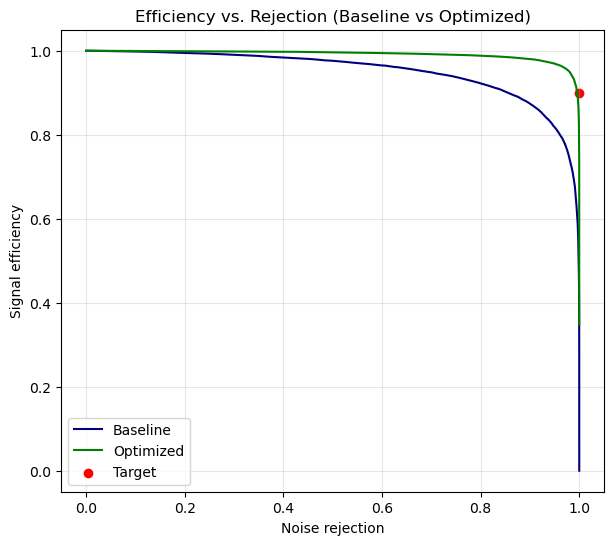

In [19]:
threshold, seff2, nrej2 = sweep_thresholds(y_val, y_val_pred2)

# Plot signal efficiency vs noise rejection
plt.figure(figsize=(7,6))
plt.plot(nrej, seff, label='Baseline', color='navy')
plt.plot(nrej2, seff2, label='Optimized', color='green')
plt.scatter([0.999], [0.90], color='red', label='Target')
plt.xlabel('Noise rejection') # True negative response
plt.ylabel('Signal efficiency') # True positive response
plt.title('Efficiency vs. Rejection (Baseline vs Optimized)')
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

In [20]:
# Choose operating threshold achieving >=99.9% noise rejection, maximize signal efficiency
mask = nrej2 >= 0.999
if mask.any():
    idx2 = np.argmax(seff2[mask])
    best_thr2 = threshold[mask][idx2]
    best_seff2 = seff2[mask][idx2]
    best_nrej2 = nrej2[mask][idx2]
else:
    # fallback to best trade-off by maximizing seff + nrej
    idx2 = np.argmax(seff2 + nrej2)
    best_thr2 = threshold[idx2]
    best_seff2 = seff2[idx2]
    best_nrej2 = nrej2[idx2]

print(f'[Optimized] Operating threshold: {best_thr2:.4f}')
print(f'[Optimized] Signal efficiency: {best_seff2*100:.2f}%')
print(f'[Optimized] Noise rejection:  {best_nrej2*100:.2f}%')

# Confusion matrix at operating point
y_pred_op2 = (y_val_pred2 >= best_thr2).astype(int)
tp = ((y_pred_op2==1) & (y_val==1)).sum()
tn = ((y_pred_op2==0) & (y_val==0)).sum()
fp = ((y_pred_op2==1) & (y_val==0)).sum()
fn = ((y_pred_op2==0) & (y_val==1)).sum()
print('TP, TN, FP, FN =', tp, tn, fp, fn)

[Optimized] Operating threshold: 0.9790
[Optimized] Signal efficiency: 84.27%
[Optimized] Noise rejection:  99.90%
TP, TN, FP, FN = 16871 99881 98 3150


## Final comments
It is observed that now the signal efficiency of our model has been optimized drastically from 49.23% to 84.27%, while keeping a high noise rejection of 99.9%. While it could still be further improved, from our starting it's already a great win.